## Sentiment Analysis of Amazon Reviews

Saved as 'distilbert-base-uncased-MC-News' on my HuggingFace profile

Source for the Dataset: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

### Exploratory Data Analysis & Preprocessing in Pandas

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from pathlib import Path

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import datasets
from datasets import Dataset, DatasetDict, load_metric

import transformers
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer, get_scheduler, set_seed, DataCollatorWithPadding

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Versions of Many Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.4
NumPy:             1.23.3
Torch:             1.12.1


#### Ingest, Concatenate, & Preprocess Data

In [3]:
data_1 = pd.read_csv('~/Desktop/News Text Summarization/CNN_Articles_clean_sm.csv', engine="c")
data_2 = pd.read_csv('~/Desktop/News Text Summarization/CNN_Articles_clean-LG.csv', engine="c")

data = pd.concat([data_1, data_2]).reset_index(drop=True)

data.dropna(inplace=True)

data['text'] = data['Headline'] + ' : ' + data['Second headline'] + ' : ' + data['Description']

data.drop(columns=['Index', 'Url', 'Keywords', 'Date published', 'Section', 'Second headline', 'Article text', 'Headline', 'Description', 'Author'], inplace=True)
data.rename(columns={'Category' : 'labels'}, inplace=True)

data.head()

,labels,text
0,news,"There's a shortage of truckers, but TuSimple t..."
1,news,Bioservo's robotic 'Ironhand' could protect fa...
2,news,This swarm of robots gets smarter the more it ...
3,business,Russia is no longer an option for investors. T...
4,business,Russian energy investment ban part of new EU s...


In [4]:
cols2keep = ['news', 'sport', 'politics', 'business', 'health', 'entertainment']
data = data[data['labels'].isin(cols2keep)]

data['labels'].value_counts()

news             19680
sport            17717
politics          2536
business           958
health             609
entertainment      471
Name: labels, dtype: int64

In [5]:
unique_labels = data['labels'].unique()

label_converter_dict = {'news' : 0, 'business' : 1, 'health' : 2, 'entertainment' : 3, 'sport' : 4, 'politics' : 5}

num_of_labels = len(unique_labels)
print(unique_labels, '\n', num_of_labels)

['news' 'business' 'health' 'entertainment' 'sport' 'politics'] 
 6


#### Visualize: Histogram of Text Lengths

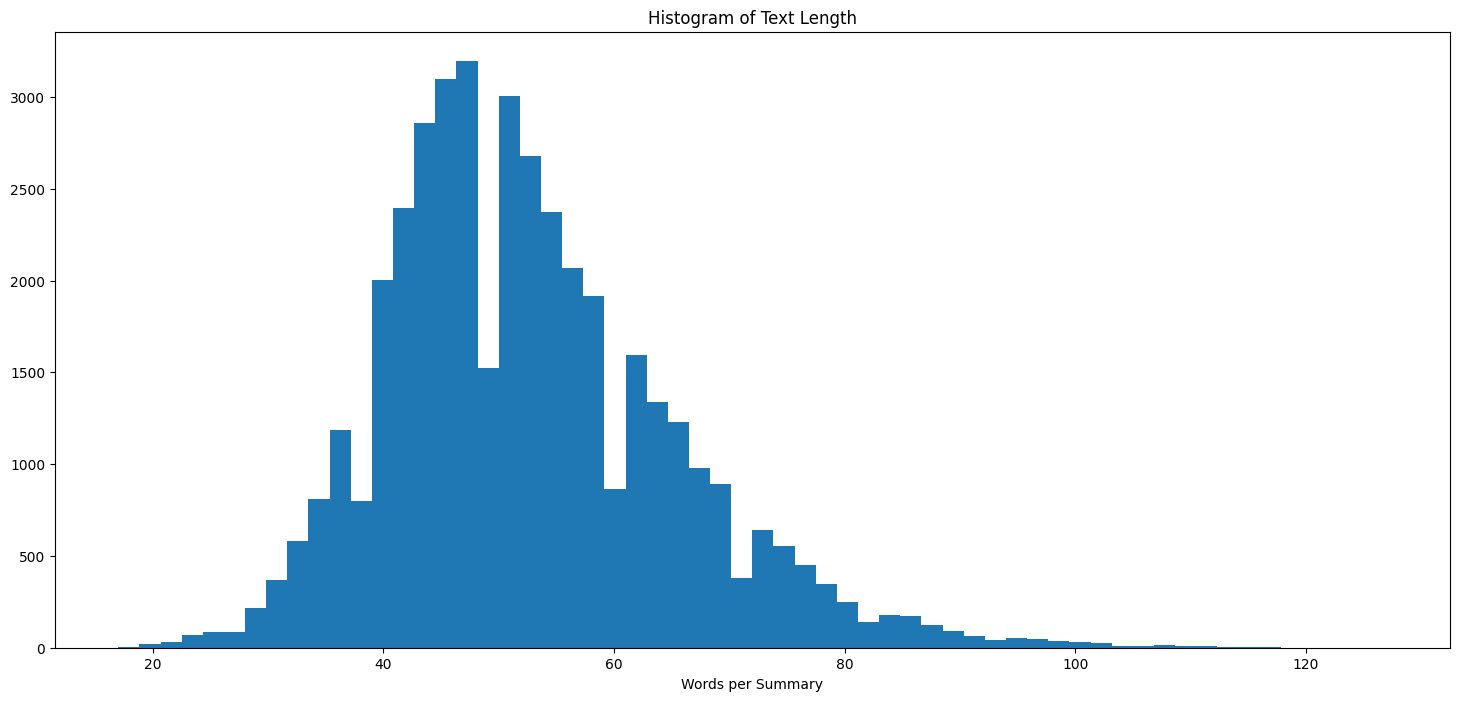

In [6]:
data['Text Length'] = data['text'].str.split().str.len()
data.hist('Text Length', grid=False, bins=60, figsize=(18,8))

plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Summary')
plt.show()

#### Visualize Description Lengths (By Output Class)

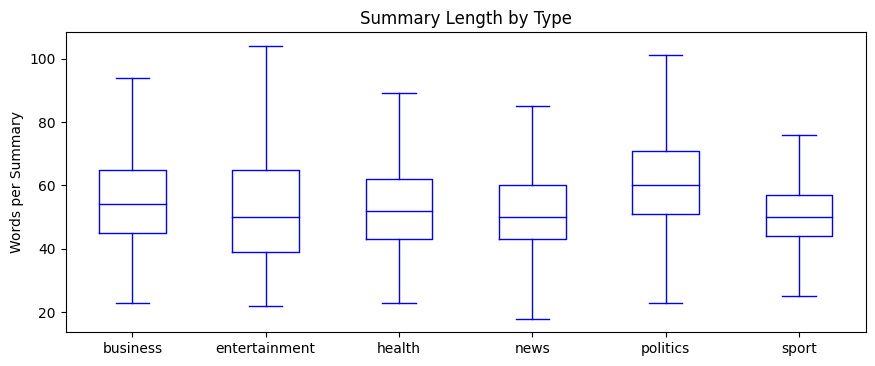

In [7]:
data.boxplot("Text Length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Summary Length by Type')
plt.xlabel('')
plt.ylabel('Words per Summary')
plt.show()

#### Final Data Preprocessing

In [8]:
data = data[data['Text Length'] < 120]

data = data.drop(columns=['Text Length'])

# Convert Labels from String Values to Integer Values
data['labels'].replace(label_converter_dict, inplace=True)

data.head()

,labels,text
0,0,"There's a shortage of truckers, but TuSimple t..."
1,0,Bioservo's robotic 'Ironhand' could protect fa...
2,0,This swarm of robots gets smarter the more it ...
3,1,Russia is no longer an option for investors. T...
4,1,Russian energy investment ban part of new EU s...


### Regular Project

#### Basic Constants/Values

In [9]:
model_ckpt = 'distilbert-base-uncased'
device="cpu"
max_input_length = int(round(120*1.3,0))
set_seed(42)
batch_size = 64

#### Convert Pandas DataFrame to Dataset; Then Split into Train/Test/Valid Datasets

In [10]:
# Convert pandas dataframe to a dataset
dataset = Dataset.from_pandas(data)

# Split the datasetdict into train/test/valid subsets
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print('training data shape:', dataset['train'].shape)
print('testing data shape:', dataset['test'].shape)
print('validation data shape:', dataset['valid'].shape)
print(dataset['train'].features)

training data shape: (33575, 3)
testing data shape: (4197, 3)
validation data shape: (4197, 3)
{'labels': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Tokenize Entire Dataset

In [11]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_input_length, return_tensors="np")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = dataset.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['valid'].shape)

100%|██████████| 1/1 [00:03<00:00,  3.12s/ba]

training data shape: (33575, 5)
testing data shape: (4197, 5)
validation data shape: (4197, 5)


#### Print Example to Ensure Edits Worked as Expected

In [12]:
print(encoded_data['train'].features)
print(encoded_data['train'])

{'labels': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 33575
})


#### Instantiate Model

In [13]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_of_labels).to(device))
model.config.num_labels

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

6

#### Ensure git lfs is Installed; Remember to Enter Access Token

In [14]:
!git lfs install

# HuggingFace Access Token ...

Git LFS initialized.


#### Define Function to Compute Metrics

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_score": f1}

#### Instantiate TrainingArguments

In [16]:
num_of_epochs = 4
logging_steps = (len(encoded_data['train']) // batch_size)
learning_rate=2e-5
steps = 100

model_name = f"{model_ckpt}-MC-News"

training_args = TrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=batch_size, 
                        per_device_eval_batch_size=batch_size, 
                        weight_decay=0.01,
                        log_level="error",
                        logging_strategy='epoch', 
                        hub_strategy="checkpoint",
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        save_total_limit=15,
                        load_best_model_at_end=True,
                        metric_for_best_model="f1_score",
                        greater_is_better=True,
                        logging_first_step=True,
                        disable_tqdm=False,
                        push_to_hub=True)

#### Instantiate Data Collator

In [17]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Correctly Compute Loss for Imbalanced Classes

In [18]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [19]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-MC-News into local empty directory.


#### Train Model

In [20]:
trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 1/2100 [01:06<38:54:00, 66.72s/it]

{'loss': 1.7287, 'learning_rate': 1.999047619047619e-05, 'epoch': 0.0}


 25%|██▌       | 525/2100 [7:56:31<19:52:42, 45.44s/it]

{'loss': 0.2026, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


                                                       
 25%|██▌       | 525/2100 [8:11:18<19:52:42, 45.44s/it]

{'eval_loss': 0.08868420124053955, 'eval_accuracy': 0.9571122230164403, 'eval_f1_score': 0.9569485735778513, 'eval_runtime': 885.8628, 'eval_samples_per_second': 4.738, 'eval_steps_per_second': 0.075, 'epoch': 1.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
 50%|█████     | 1050/2100 [15:13:04<12:01:29, 41.23s/it]

{'loss': 0.0641, 'learning_rate': 1e-05, 'epoch': 2.0}


                                                         
 50%|█████     | 1050/2100 [15:27:52<12:01:29, 41.23s/it]

{'eval_loss': 0.082323357462883, 'eval_accuracy': 0.9611627352871098, 'eval_f1_score': 0.9608140546463985, 'eval_runtime': 888.2548, 'eval_samples_per_second': 4.725, 'eval_steps_per_second': 0.074, 'epoch': 2.0}


 75%|███████▌  | 1575/2100 [22:29:30<6:16:22, 43.02s/it]  

{'loss': 0.0383, 'learning_rate': 5e-06, 'epoch': 3.0}


                                                        
 75%|███████▌  | 1575/2100 [22:44:20<6:16:22, 43.02s/it]

{'eval_loss': 0.08899662643671036, 'eval_accuracy': 0.9621157969978557, 'eval_f1_score': 0.9624965133979526, 'eval_runtime': 890.1552, 'eval_samples_per_second': 4.715, 'eval_steps_per_second': 0.074, 'epoch': 3.0}


100%|██████████| 2100/2100 [29:50:17<00:00, 42.66s/it]    

{'loss': 0.0242, 'learning_rate': 0.0, 'epoch': 4.0}


                                                      
100%|██████████| 2100/2100 [30:04:52<00:00, 42.66s/it]

{'eval_loss': 0.09647069871425629, 'eval_accuracy': 0.9642601858470335, 'eval_f1_score': 0.9639528833250911, 'eval_runtime': 875.5701, 'eval_samples_per_second': 4.793, 'eval_steps_per_second': 0.075, 'epoch': 4.0}


100%|██████████| 2100/2100 [30:05:48<00:00, 51.59s/it]

{'train_runtime': 108348.1995, 'train_samples_per_second': 1.24, 'train_steps_per_second': 0.019, 'train_loss': 0.08301882198878698, 'epoch': 4.0}


TrainOutput(global_step=2100, training_loss=0.08301882198878698, metrics={'train_runtime': 108348.1995, 'train_samples_per_second': 1.24, 'train_steps_per_second': 0.019, 'train_loss': 0.08301882198878698, 'epoch': 4.0})

### Assessing the Results of the Fine-Tuned Model

#### Calculate Predictions for Fine-Tuned Model

In [21]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

100%|██████████| 66/66 [15:05<00:00, 13.71s/it]


{'test_loss': 0.09647069871425629,
 'test_accuracy': 0.9642601858470335,
 'test_f1_score': 0.9639528833250911,
 'test_runtime': 919.9739,
 'test_samples_per_second': 4.562,
 'test_steps_per_second': 0.072}

#### Extract Last Hidden States

In [22]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}   
    with torch.no_grad():
        last_hidden_state = model(**inputs)[0]
    return {"hidden_state" : last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format("torch", columns=['input_ids', 'attention_mask', 'labels']) 

hidden_data = encoded_data.map(extract_hidden_states, batched=True)
print(hidden_data)

100%|██████████| 5/5 [17:29<00:00, 209.88s/ba]


DatasetDict({
    train: Dataset({
        features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 33575
    })
    test: Dataset({
        features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 4197
    })
    valid: Dataset({
        features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 4197
    })
})


#### Create Feature Matrix

In [23]:
X_train = np.array(hidden_data['train']['hidden_state'])
X_valid = np.array(hidden_data['valid']['hidden_state'])
y_train = np.array(hidden_data['train']['labels'])
y_valid = np.array(hidden_data['valid']['labels'])
X_train.shape, X_valid.shape

((33575,), (4197,))

#### Define Function to Display Confusion Matrix

In [24]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(11, 11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Convert Logits to Predictions; Display Confusion Matrix for Fine-Tuned Model

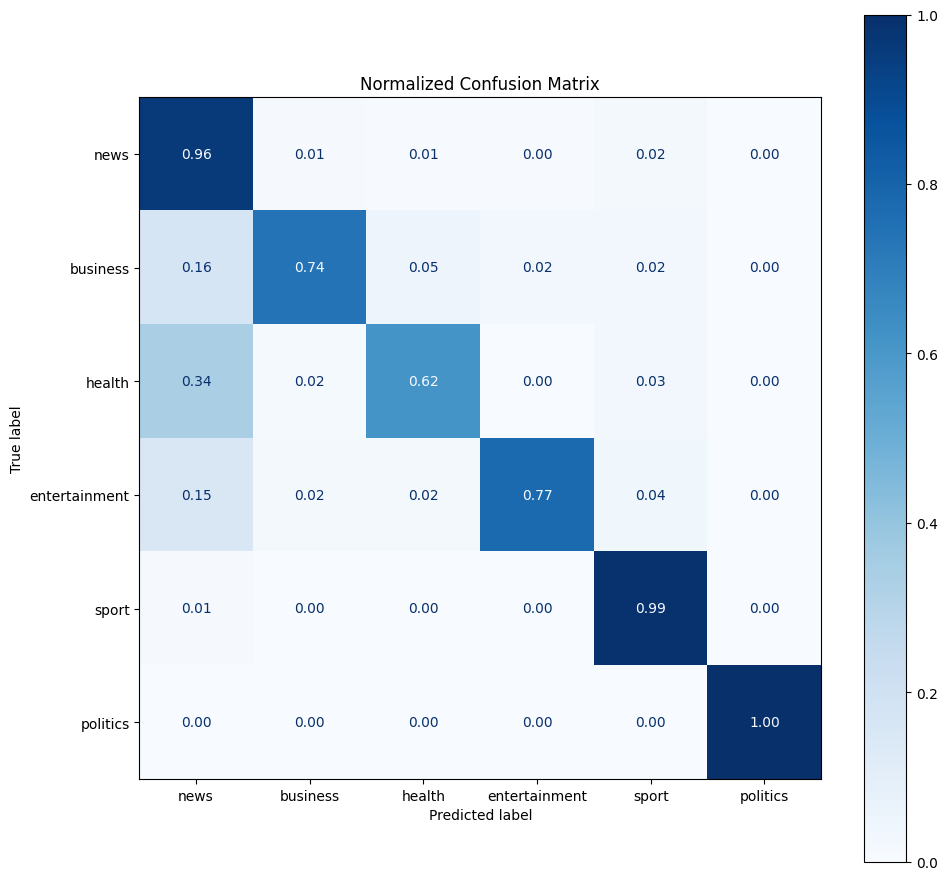

In [30]:
names_of_labels = [((x+1)*1.0) for x in range(0, 6)]

labels_int_to_str = ['news', 'business', 'health', 'entertainment', 'sport', 'politics']

y_preds = np.argmax(output_predictions.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels=labels_int_to_str)

### Final Steps

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [31]:
trainer.push_to_hub(commit_message="All Dunn!!!")

#### Save Exact Dataset Splits

In [27]:
dataset['train'].to_csv('CNN_News_summarization-training_data.csv', index=None)
dataset['test'].to_csv('CNN_News_summarization-testing_data.csv', index=None)
dataset['valid'].to_csv('CNN_News_summarization-validation_data.csv', index=None)

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  9.44ba/s]


1340237